In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
from scipy.special import erf

In [4]:
epoch_n_91t, wavelength_nugent_91t, flux_nugent_91t = np.loadtxt('../data/info_files/nugent_91t_templates.dat', unpack = True)
epoch_n_91bg, wavelength_nugent_91bg, flux_nugent_91bg = np.loadtxt('../data/info_files/nugent_91bg_templates.dat', unpack = True)

In [5]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_m2 = flux_salt - 3.06*salt_corr #dm15=1.61
flux_salt_p1 = flux_salt + 1.85*salt_corr #dm15=.84
# flux_salt_m2 = flux_salt - 2.68*salt_corr #using fit from guy07
# flux_salt_p1 = flux_salt + 1.76*salt_corr #using fit from guy07

In [6]:
salt_temps_m2 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_m2[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_m2[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_m2[i])
    first = False
    
salt_temps_p1 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_p1[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_p1[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_p1[i])
    first = False

In [7]:
nug_temps_91t = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91t):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91t[float(epoch_n_91t[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91t[i]]
        temp_flux = [flux_nugent_91t[i]]
    else:
        temp_wave.append(wavelength_nugent_91t[i])
        temp_flux.append(flux_nugent_91t[i])
    first = False
    
nug_temps_91bg = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91bg):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91bg[float(epoch_n_91bg[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91bg[i]]
        temp_flux = [flux_nugent_91bg[i]]
    else:
        temp_wave.append(wavelength_nugent_91bg[i])
        temp_flux.append(flux_nugent_91bg[i])
    first = False

In [8]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.supernova(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    return s_template

In [9]:
m2_salt_template = make_obj_from_template(salt_temps_m2[0.][0], salt_temps_m2[0.][1])
p1_salt_template = make_obj_from_template(salt_temps_p1[0.][0], salt_temps_p1[0.][1])
nug91t_template = make_obj_from_template(nug_temps_91t[0.][0], nug_temps_91t[0.][1])
nug91bg_template = make_obj_from_template(nug_temps_91bg[0.][0], nug_temps_91bg[0.][1])

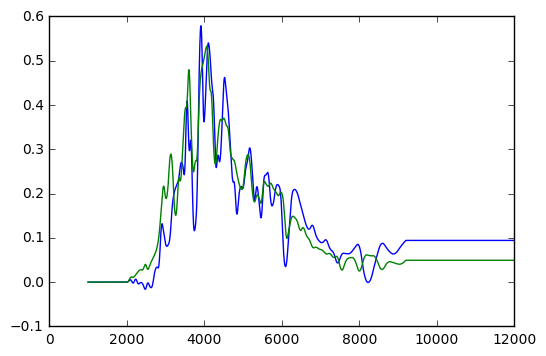

In [10]:
plt.plot(m2_salt_template.wavelength, m2_salt_template.flux)
plt.plot(p1_salt_template.wavelength, p1_salt_template.flux)
plt.show()

In [11]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'"]

In [12]:
composites_p1, sn_arrays_p1, boot_sn_arrays_p1 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'
104 questionable files currently ignored
(0, 'questionable spectra removed', 24, 'spectra left')
(0, 'Peculiar Ias removed', 24, 'spectra left')
24 valid spectra found
Arrays cleaned
0 spectra may have telluric contamination


composite.py:1131: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if template.RMSE != None:
composite.py:1168: RuntimeWarning: divide by zero encountered in divide
  error = 1./np.sqrt(template.ivar)


15 total SNe
15 SNs with host corrections


composite.py:445: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  guess = np.average(template.flux[template.x1:template.x2])/np.average(uSN.flux[uSN.x1:uSN.x2])
gini.py:43: RuntimeWarning: invalid value encountered in absolute
  g_diff = np.absolute(g_wi - g_wj)
gini.py:48: RuntimeWarning: invalid value encountered in double_scalars
  gini_coeffs.append(gini_num/gini_denom)


Gini balancing...
Balanced after 5 iterations
Bootstrapping


composite.py:506: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = temp_flux[pos1:pos2] - comp.flux[pos1:pos2]


scaling boots...
computing confidence intervals...


In [13]:
query_db.set_min_num_spec(composites_p1, 5)

In [14]:
composites_p1[0].name = "Comp"
p1_salt_template.name = "SALT2"
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

In [15]:
# print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
# query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], legend_labels = ["Composite Spectrum ($ 0.75 < \Delta m_{15} (B) < 0.90$)", "SALT2 ($\Delta m_{15} (B) = 0.84$)"])

In [16]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'"]

In [17]:
composites_m2, sn_arrays_m2, boot_sn_arrays_m2 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'
104 questionable files currently ignored
(1, 'questionable spectra removed', 51, 'spectra left')
(5, 'Peculiar Ias removed', 46, 'spectra left')
44 valid spectra found
Arrays cleaned
1 spectra may have telluric contamination
15 total SNe
15 SNs with host corrections
Gini balancing...
Balanced after 9 iterations
Bootstrapping
scaling boots...
computing confidence intervals...


In [18]:
query_db.set_min_num_spec(composites_m2, 1)

In [19]:
composites_m2[0].name = "Comp"
m2_salt_template.name = "SALT-II"
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

In [20]:
# print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
# query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], 
#                      legend_labels = ["Composite Spectrum ($ 1.5 < \Delta m_{15} (B) < 1.7$)", "SALT-II ($\Delta m_{15} (B) = 1.61$)"])

## Warp Hsiao Templates

In [21]:
phase_h, wavelength_hsiao, flux_hsiao = np.loadtxt('../data/info_files/hsiao_template.dat', unpack = True)

In [22]:
hsiao_temps = {}
phase_list = []
first = True
for i, phase in enumerate(phase_h):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            hsiao_temps[float(phase_h[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_hsiao[i]]
        temp_flux = [flux_hsiao[i]]
    else:
        temp_wave.append(wavelength_hsiao[i])
        temp_flux.append(flux_hsiao[i])
    first = False

In [23]:
import pyphot
import scipy.interpolate as inter
import scipy.optimize as opt

In [24]:
def color_residuals(spline_knot_vals, true_BmV, true_VmR, spectrum, Beff = 4315.522317, Veff = 5438.689405, Reff = 6389.952199):
    print spline_knot_vals
    spline_knot_locs = [Beff, Veff, Reff]
    spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
    spline_func = inter.splev(hsiao_max[0], spline, ext = 0)
    warped_flux = spline_func*spectrum[1]

    Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

    Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

    Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag
    
    new_BmV = Bmag - Vmag
    new_VmR = Vmag - Rmag
    print new_BmV, new_VmR
    return (new_BmV - true_BmV)**2. + (new_VmR - true_VmR)**2.
#     return (new_BmV - true_BmV)**2.

In [25]:
lib = pyphot.get_library()
f = lib.find('Johnson')
# for name in f:
#     lib[name].info(show_zeropoints=True)
U = lib['GROUND_JOHNSON_U']
B = lib['GROUND_JOHNSON_B']
V = lib['GROUND_JOHNSON_V']
R = lib['GROUND_COUSINS_R']

In [26]:
phase = 0.
hsiao_max = hsiao_temps[phase]
# Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
# Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

In [27]:
# Ueff = 3709.279027
Beff = 4315.522317
Veff = 5438.689405
Reff = 6389.952199
spline_knot_locs = [Beff, Veff, Reff]
spline_knot_vals = [1.00000001, 1.0, 1.0]
spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
spline_func = inter.splev(hsiao_max[0], spline, ext = 0)

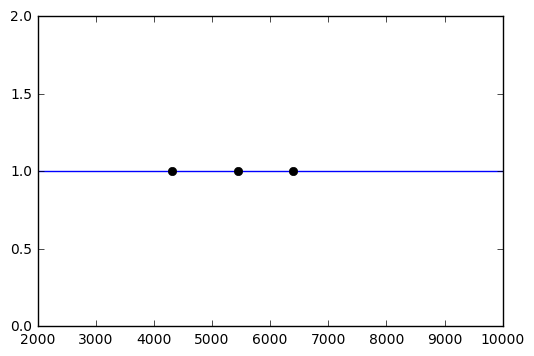

In [28]:
plt.plot(hsiao_max[0], spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.xlim([2000,10000])
plt.ylim([0,2])
plt.show()

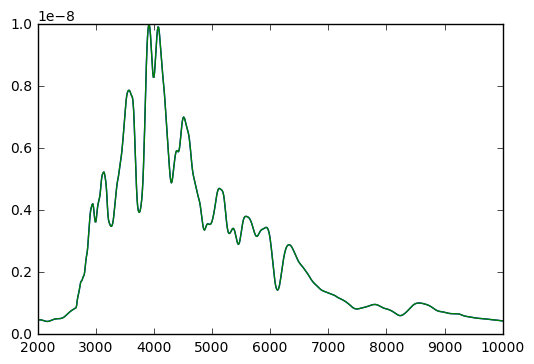

In [29]:
warped_hsiao = spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [30]:
Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag, Vmag, Rmag
print Bmag - Vmag, Vmag - Rmag

Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag - Vmag, Vmag - Rmag

-0.0371200866077 0.0423958457655 0.0355232036651
-0.0795159323732 0.00687264210036
-0.079515943888 0.00687264266107


In [31]:
comp = composites_p1[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [32]:
print true_Bmag, true_Vmag, true_Rmag

-19.3886342107 -19.2425302011 -19.1269390082


In [33]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag
print true_BmV, true_VmR

-0.1461040096 -0.115591192946


In [34]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 1.03333334  1.03333333  0.95      ]
-0.0782875049926 -0.0828109201571
[ 1.05000001  1.05        0.9       ]
-0.0773296001607 -0.158197606426
[ 1.05555557  0.97222222  0.96666667]
-0.173604599397 0.00561625451201
[ 1.0925926   1.0037037   0.94444444]
-0.176182794144 -0.052436752098
[ 1.1388889   1.00555556  0.91666667]
-0.221236251393 -0.0831876191674
[ 1.07098767  1.00617284  0.90740741]
-0.150140748126 -0.0991165667078
[ 1.08148149  1.00925926  0.86111111]
-0.157387868103 -0.15787933981
[ 1.07572018  1.05658436  0.90123457]
-0.0981564650392 -0.162126724842
[ 1.12620029  1.01097394  0.88539095]
-0.202139090585 -0.126962707338
[ 1.08934615  1.04545039  0.8515775 ]
-0.124603128033 -0.210044459874
[ 1.09178

In [35]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

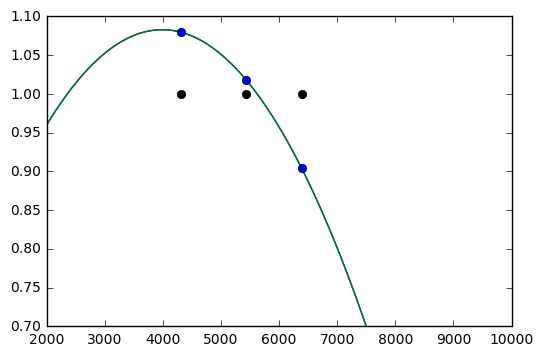

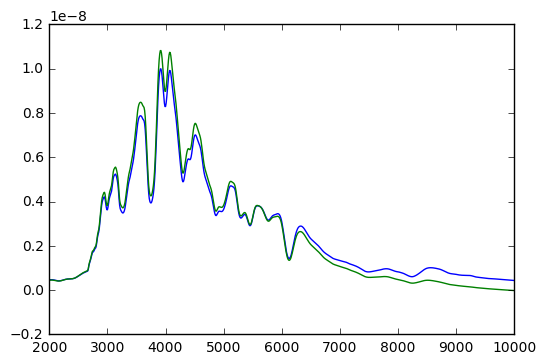

In [36]:
warped_hsiao = best_spline_func*hsiao_max[1]
# plt.plot(hsiao_max[0], hsiao_max[1])
# plt.plot(hsiao_max[0], warped_hsiao)
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.1])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [37]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template = composite.supernova(wave_interp_h, flux_interp_h)
h_template.phase_array = np.zeros(len(flux_interp_h))

In [40]:
wavelength_f08_lowdm, flux_f08_lowdm, low_f08_lowdm, up_f08_lowdm = np.loadtxt('../data/foley/foley=0.02=1.2=-0.27=0.35=13.flm', unpack = True)
wavelength_f08_highdm, flux_f08_highdm, low_f08_highdm, up_f08_highdm = np.loadtxt('../data/foley/foley=0.01=-0.3=0.43=0.04=12.flm', unpack = True)

In [41]:
#lowdm f08
wave_interp_f08_lowdm = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_f08_lowdm = inter.splrep(wavelength_f08_lowdm, flux_f08_lowdm)
low_spl_f08_lowdm = inter.splrep(wavelength_f08_lowdm, low_f08_lowdm)
up_spl_f08_lowdm = inter.splrep(wavelength_f08_lowdm, up_f08_lowdm)

flux_interp_lowdm = inter.splev(wave_interp_f08_lowdm, flux_spl_f08_lowdm, ext = 3)
low_interp_lowdm = inter.splev(wave_interp_f08_lowdm, low_spl_f08_lowdm, ext = 3)
up_interp_lowdm = inter.splev(wave_interp_f08_lowdm, up_spl_f08_lowdm, ext = 3)

f08_template_lowdm = composite.supernova(wave_interp_f08_lowdm, flux_interp_lowdm, low_conf=low_interp_lowdm, up_conf=up_interp_lowdm)
f08_template_lowdm.phase_array = np.zeros(len(flux_interp_lowdm))

#highdm f08
wave_interp_f08_highdm = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_f08_highdm = inter.splrep(wavelength_f08_highdm, flux_f08_highdm)
low_spl_f08_highdm = inter.splrep(wavelength_f08_highdm, low_f08_highdm)
up_spl_f08_highdm = inter.splrep(wavelength_f08_highdm, up_f08_highdm)

flux_interp_highdm = inter.splev(wave_interp_f08_highdm, flux_spl_f08_highdm, ext = 3)
low_interp_highdm = inter.splev(wave_interp_f08_highdm, low_spl_f08_highdm, ext = 3)
up_interp_highdm = inter.splev(wave_interp_f08_highdm, up_spl_f08_highdm, ext = 3)

f08_template_highdm = composite.supernova(wave_interp_f08_highdm, flux_interp_highdm, low_conf=low_interp_highdm, up_conf=up_interp_highdm)
f08_template_highdm.phase_array = np.zeros(len(flux_interp_highdm))

Comp v =  10411.4692043
Hsiao v =  10997.3983334
Nugent v =  3177.33131873
SALT2 v =  10704.3006753
Foley v =  12074.3661582
0.844213110036
Phase:  0.385874335001
dm15:  0.844213110036
Redshift:  0.0248842939473


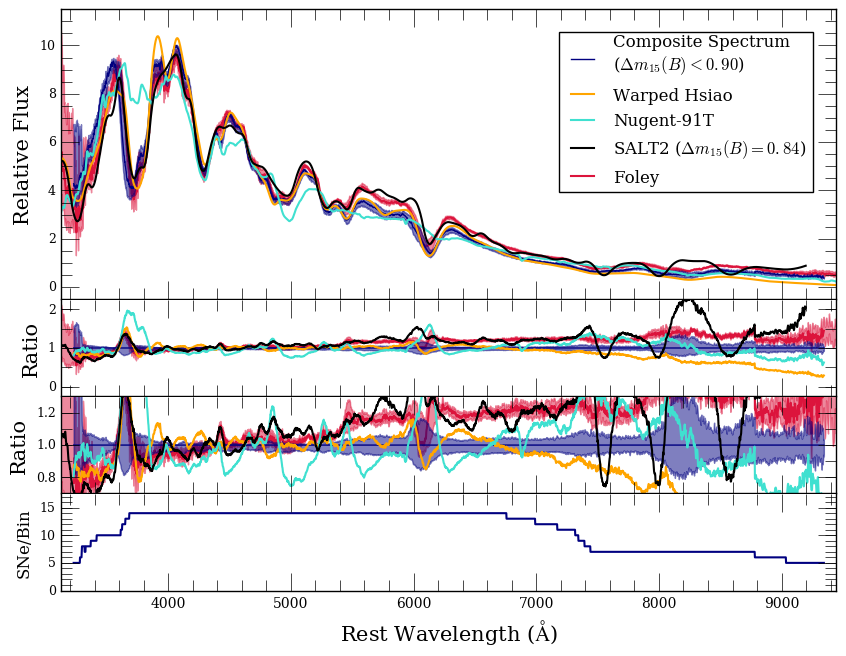

In [46]:
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
    
srange = np.where((p1_salt_template.wavelength > 2000.) & (p1_salt_template.wavelength < 9200))[0]
p1_salt_template.x1 = srange[0]
p1_salt_template.x2 = srange[-1]

comps_and_temps.append(h_template)
comps_and_temps.append(nug91t_template)
comps_and_temps.append(p1_salt_template)
comps_and_temps.append(f08_template_lowdm)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "Nugent"
comps_and_temps[3].name = "SALT2"
comps_and_temps[4].name = "Foley"
for comp in comps_and_temps:
    v_strong, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2],comp.flux[comp.x1:comp.x2], 5900., 6300.)
    print comp.name, 'v = ', v_strong
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
# query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2], comps_and_temps[3]], include_spec_bin=True, 
#                      legend_labels = ["Composite Spectrum \n($\Delta m_{15} (B) < 0.90$)", "Warped Hsiao", "Nugent-91T", "SALT2 ($\Delta m_{15} (B) = 0.84$)"],
# #                      rm_last_label=True,
#                      savename = 'template_comparisons_updated/temp_max_light_lowdm15')
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2], comps_and_temps[3], comps_and_temps[4]], include_spec_bin=True, text='Maximum Light',
                     legend_labels = ["This Paper \n($\Delta m_{15} (B) < 0.90$)", "Warped Hsiao", "Nugent-91T", "SALT2 ($\Delta m_{15} (B) = 0.84$)", "Foley"])

In [47]:
comp = composites_m2[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [48]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag

In [49]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 0.95000001  1.03333333  1.03333333]
0.017914059335 0.00232544400635
[ 0.90000001  1.05        1.05      ]
0.100069934719 -0.00121737273614
[ 0.96666668  0.97222222  1.05555556]
-0.0742503589153 0.0934895621891
[ 0.94444445  1.0037037   1.09259259]
-0.0109846679242 0.0936939641529
[ 0.91666668  1.00555556  1.13888889]
0.0245849252909 0.134204480088
[ 0.96296297  1.05246914  1.0617284 ]
0.0232973879331 0.0114476301954
[ 0.96111112  1.09259259  1.06481481]
0.0702812289393 -0.0276413837889
[ 0.90493828  1.05967078  1.07510288]
0.103967217246 0.0141588646947
[ 0.92870371  1.04475309  1.06882716]
0.0566461091941 0.0250120218383
[ 0.94074075  1.03395062  1.1154321 ]
0.0281091727085 0.0826519035394
[ 0.93611112 

In [50]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

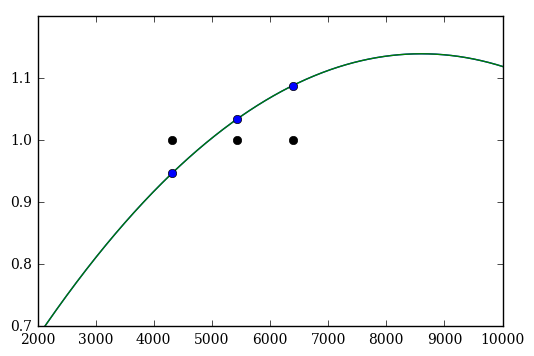

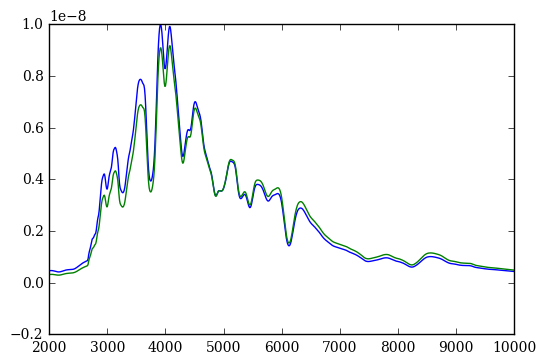

In [51]:
warped_hsiao = best_spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.2])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [52]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template_2 = composite.supernova(wave_interp_h, flux_interp_h)
h_template_2.phase_array = np.zeros(len(flux_interp_h))

Comp v =  11290.7621201
Hsiao v =  10997.3983334
SALT2 v =  12466.8773158
Foley v =  11095.1566954
Phase:  -0.162589293073
dm15:  1.59607465374
Redshift:  0.015543794002


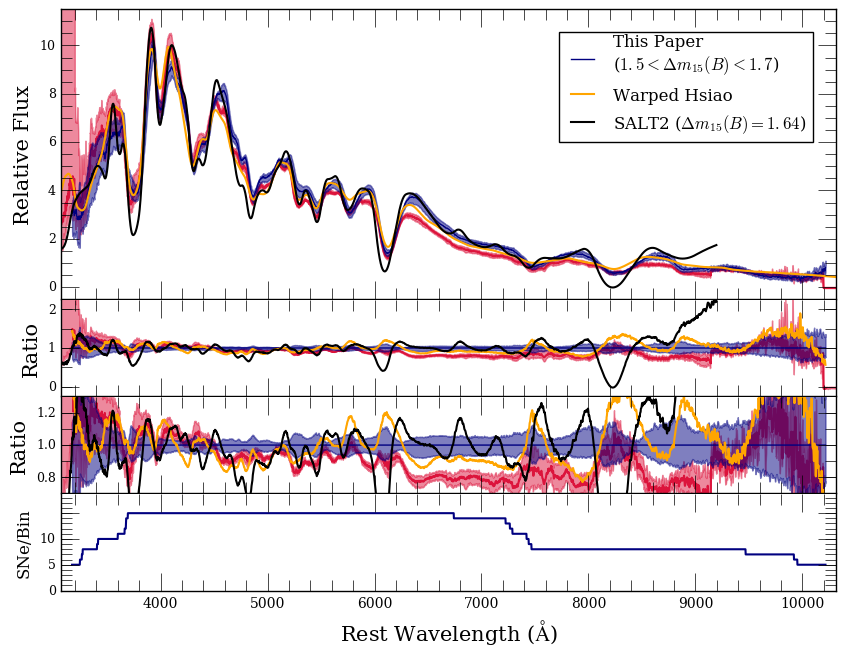

In [55]:
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
    
srange = np.where((m2_salt_template.wavelength > 2000.) & (m2_salt_template.wavelength < 9200))[0]
m2_salt_template.x1 = srange[0]
m2_salt_template.x2 = srange[-1]

comps_and_temps.append(h_template_2)
comps_and_temps.append(m2_salt_template)
comps_and_temps.append(f08_template_highdm)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "SALT2"
comps_and_temps[3].name = "Foley"
for comp in comps_and_temps:
    v_strong, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2],comp.flux[comp.x1:comp.x2], 5900., 6300.)
    print comp.name, 'v = ', v_strong
# query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2]], include_spec_bin=True, legend_labels = ["Composite Spectrum \n($ 1.5 < \Delta m_{15} (B) < 1.7$)", "Warped Hsiao", "SALT2 ($\Delta m_{15} (B) = 1.64$)"],
#                      rm_last_label=True,
#                      savename = 'template_comparisons_updated/temp_max_light_middm15')
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2], comps_and_temps[3]], include_spec_bin=True, legend_labels = ["This Paper \n($ 1.5 < \Delta m_{15} (B) < 1.7$)", "Warped Hsiao", "SALT2 ($\Delta m_{15} (B) = 1.64$)", "Foley"],
                     rm_last_label=True, text='Maximum Light')